Выполним импорт необходимых библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Загрузим набор данных (MNIST), разобьем данные на подвыборки

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))


100%|██████████| 9912422/9912422 [00:00<00:00, 106647046.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42002667.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33851480.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17477549.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data: 10000


Настроим использование графического ускорителя (если возможно)

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создадим класс НС на основе фреймворка torch

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Проверим работоспособность созданного класса НС

In [5]:
model = Net().to(device)


Создадим оптимизатор, функцию потерь и трейнер сети

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определим функцию обучения сети

In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучим модель

In [8]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.29165850282138017 Val_Loss: 0.14174661178974304
Epoch: 2 Loss: 0.1133845992699583 Val_Loss: 0.10169632793162789
Epoch: 3 Loss: 0.09130893708366651 Val_Loss: 0.08483823665866261
Epoch: 4 Loss: 0.0790467975475097 Val_Loss: 0.07914180815385971
Epoch: 5 Loss: 0.07299478122221174 Val_Loss: 0.08137973420264724
Epoch: 6 Loss: 0.06473745620841334 Val_Loss: 0.08442745800929471
Epoch: 7 Loss: 0.064776662380194 Val_Loss: 0.07570525744497564
Epoch: 8 Loss: 0.06151725916071245 Val_Loss: 0.07328030406317827
Epoch: 9 Loss: 0.05859530378177729 Val_Loss: 0.07601816120249275
Epoch: 10 Loss: 0.05611050558511743 Val_Loss: 0.07663759590508828


Построим графики потерь при обучении и валидации в зависимости от эпохи

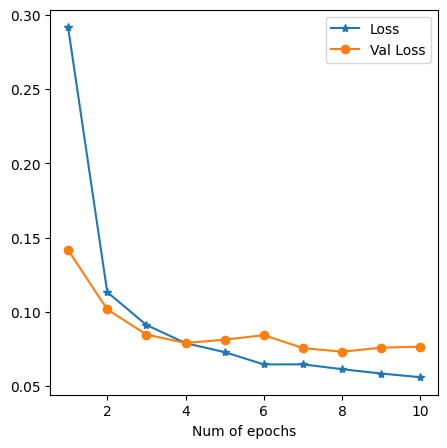

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM, I-FGSM, MI-FGSM

In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out


Создадим функцию проверки

In [11]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Построим графики успешности атак (Accuracy/epsilon) и примеры выполненных атак в зависимости от степени возмущения epsilon

Epsilon: 0	Test Accuracy = 9708 / 10000 = 0.9708
Epsilon: 0.007	Test Accuracy = 9682 / 10000 = 0.9682
Epsilon: 0.01	Test Accuracy = 9657 / 10000 = 0.9657
Epsilon: 0.02	Test Accuracy = 9600 / 10000 = 0.96
Epsilon: 0.03	Test Accuracy = 9542 / 10000 = 0.9542
Epsilon: 0.05	Test Accuracy = 9309 / 10000 = 0.9309
Epsilon: 0.1	Test Accuracy = 8277 / 10000 = 0.8277
Epsilon: 0.2	Test Accuracy = 5058 / 10000 = 0.5058
Epsilon: 0.3	Test Accuracy = 2729 / 10000 = 0.2729


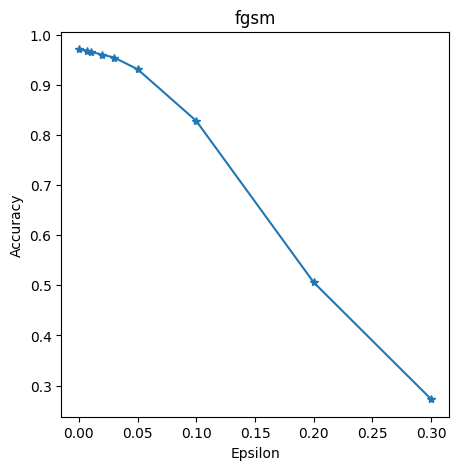

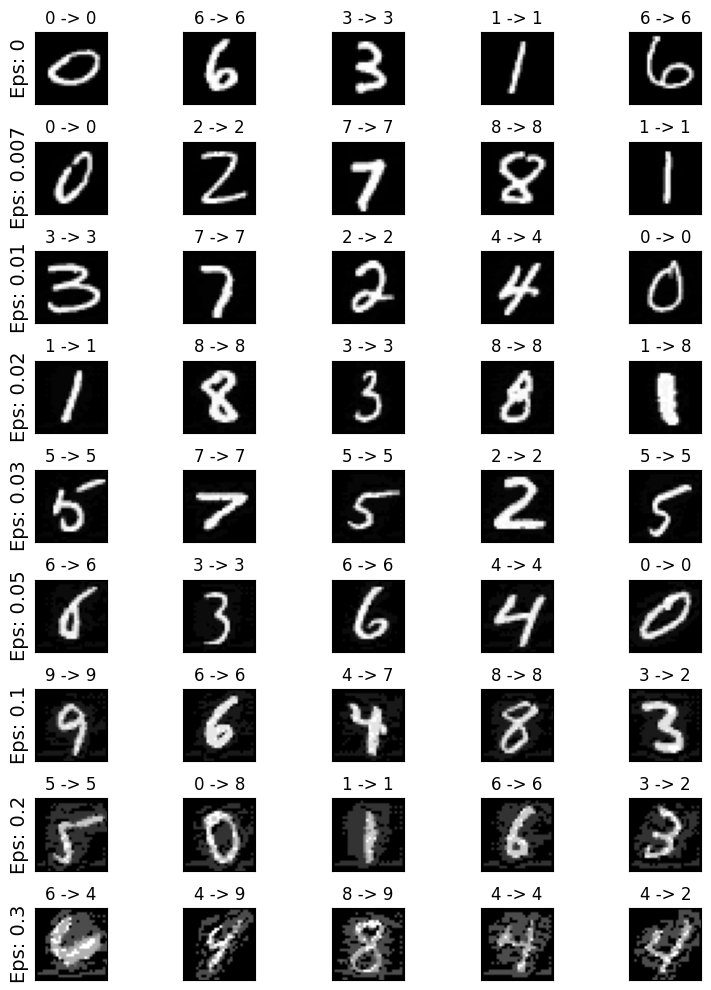

Epsilon: 0	Test Accuracy = 9722 / 10000 = 0.9722
Epsilon: 0.007	Test Accuracy = 9687 / 10000 = 0.9687
Epsilon: 0.01	Test Accuracy = 9669 / 10000 = 0.9669
Epsilon: 0.02	Test Accuracy = 9610 / 10000 = 0.961
Epsilon: 0.03	Test Accuracy = 9553 / 10000 = 0.9553
Epsilon: 0.05	Test Accuracy = 9395 / 10000 = 0.9395
Epsilon: 0.1	Test Accuracy = 8601 / 10000 = 0.8601
Epsilon: 0.2	Test Accuracy = 5723 / 10000 = 0.5723
Epsilon: 0.3	Test Accuracy = 3215 / 10000 = 0.3215


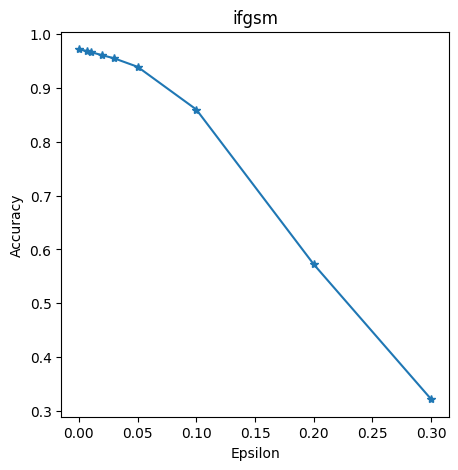

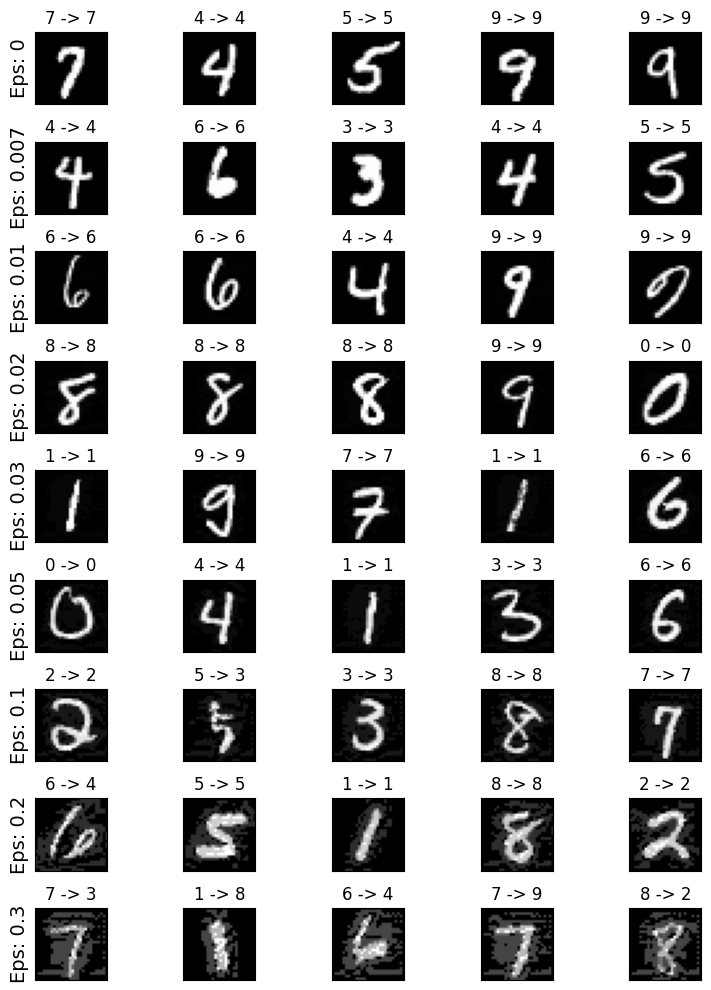

Epsilon: 0	Test Accuracy = 9704 / 10000 = 0.9704
Epsilon: 0.007	Test Accuracy = 9665 / 10000 = 0.9665
Epsilon: 0.01	Test Accuracy = 9678 / 10000 = 0.9678
Epsilon: 0.02	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.03	Test Accuracy = 9559 / 10000 = 0.9559
Epsilon: 0.05	Test Accuracy = 9382 / 10000 = 0.9382
Epsilon: 0.1	Test Accuracy = 8600 / 10000 = 0.86
Epsilon: 0.2	Test Accuracy = 5718 / 10000 = 0.5718
Epsilon: 0.3	Test Accuracy = 3169 / 10000 = 0.3169


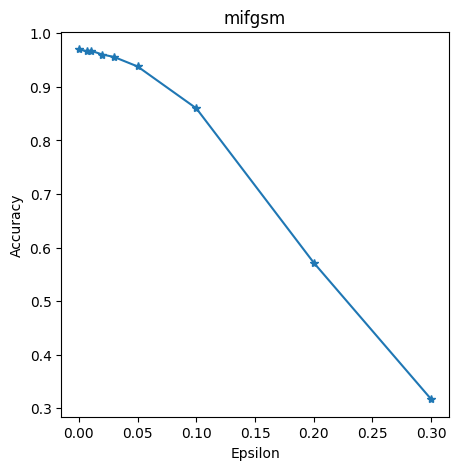

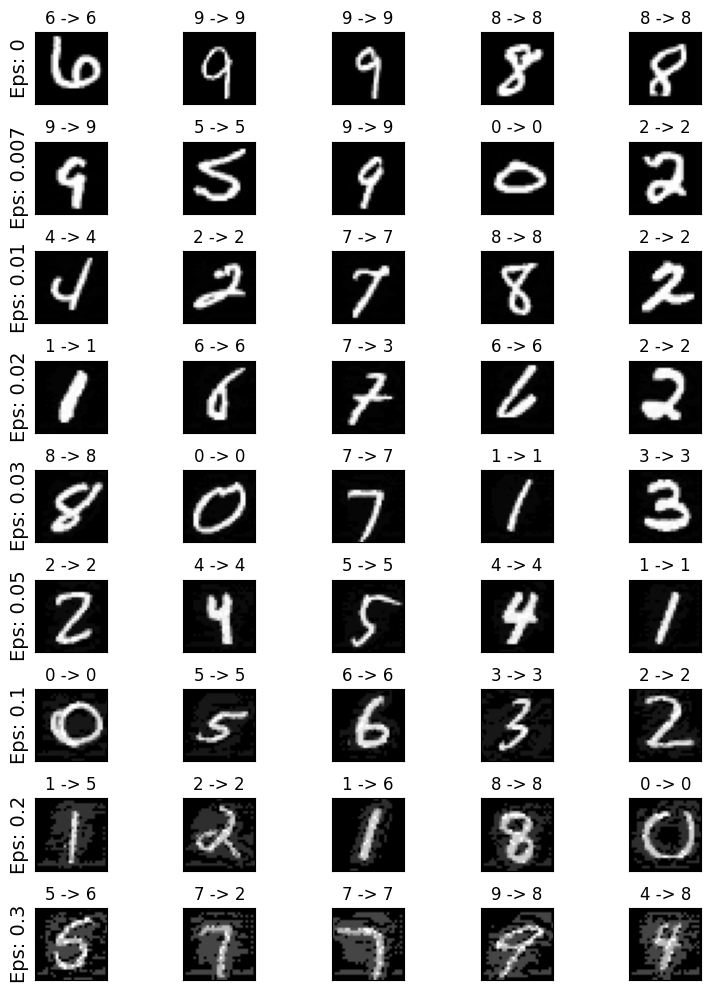

In [12]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Создадим 2 класса НС

In [13]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования

In [14]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создадим функцию защиты методом дистилляции

In [15]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Получаем результаты оценки защищенных сетей

Fitting the model...
Epoch: 1 Loss: 0.5706202287519799 Val_Loss: 8.249447653070093e-05
Epoch: 2 Loss: 0.3545042174551342 Val_Loss: 7.158523872494697e-05
Epoch: 3 Loss: 0.2684014369479434 Val_Loss: 6.209565556491725e-06
Epoch: 4 Loss: 0.1991503801513177 Val_Loss: 4.936715587973594e-07
Epoch: 5 Loss: 0.15499293439917233 Val_Loss: 2.1840261667966843e-05
Epoch: 6 Loss: 0.13230935157652426 Val_Loss: 2.0522175317455548e-05
Epoch: 7 Loss: 0.1182749427824363 Val_Loss: 1.0402818582952022e-05
Epoch: 8 Loss: 0.10521015077048566 Val_Loss: 7.633360641193577e-07
Epoch: 9 Loss: 0.09395652426495998 Val_Loss: 4.768370942542788e-11
Epoch: 10 Loss: 0.09073624960929061 Val_Loss: 2.0621534349629655e-08


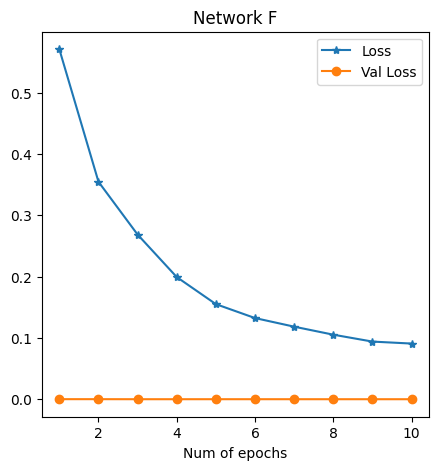

Fitting the model...
Epoch: 1 Loss: 0.6908011980243247 Val_Loss: 5.4475905746221544e-05
Epoch: 2 Loss: 0.47934048698511544 Val_Loss: 0.00015452935751527548
Epoch: 3 Loss: 0.43145106536227606 Val_Loss: 0.00043453699350357055
Epoch: 4 Loss: 0.38570553604473884 Val_Loss: 1.327155469916761e-05
Epoch: 5 Loss: 0.33855904813294896 Val_Loss: 0.00010562587110325694
Epoch: 6 Loss: 0.2970336308658502 Val_Loss: 7.979812920093536e-05
Epoch: 7 Loss: 0.2704591011468641 Val_Loss: 2.7051750384271144e-05
Epoch: 8 Loss: 0.2409409079124368 Val_Loss: 3.921909950577174e-09
Epoch: 9 Loss: 0.22466166278708538 Val_Loss: 0.00040194199084753565
Epoch: 10 Loss: 0.20263305166835704 Val_Loss: 9.179073458653875e-10


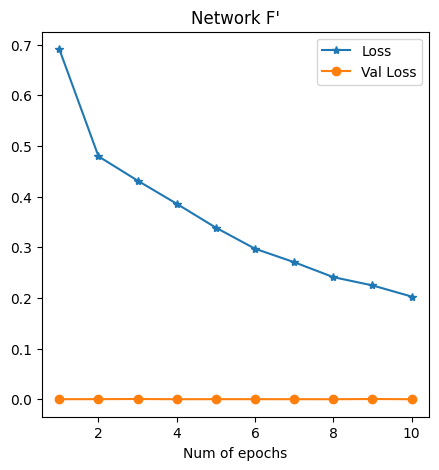

Epsilon: 0	Test Accuracy = 9149 / 10000 = 0.9149
Epsilon: 0.007	Test Accuracy = 9098 / 10000 = 0.9098
Epsilon: 0.01	Test Accuracy = 9055 / 10000 = 0.9055
Epsilon: 0.02	Test Accuracy = 8978 / 10000 = 0.8978
Epsilon: 0.03	Test Accuracy = 8898 / 10000 = 0.8898
Epsilon: 0.05	Test Accuracy = 8599 / 10000 = 0.8599
Epsilon: 0.1	Test Accuracy = 7632 / 10000 = 0.7632
Epsilon: 0.2	Test Accuracy = 4428 / 10000 = 0.4428
Epsilon: 0.3	Test Accuracy = 1825 / 10000 = 0.1825
Epsilon: 0	Test Accuracy = 9125 / 10000 = 0.9125
Epsilon: 0.007	Test Accuracy = 9112 / 10000 = 0.9112
Epsilon: 0.01	Test Accuracy = 9119 / 10000 = 0.9119
Epsilon: 0.02	Test Accuracy = 8984 / 10000 = 0.8984
Epsilon: 0.03	Test Accuracy = 8875 / 10000 = 0.8875
Epsilon: 0.05	Test Accuracy = 8629 / 10000 = 0.8629
Epsilon: 0.1	Test Accuracy = 7678 / 10000 = 0.7678
Epsilon: 0.2	Test Accuracy = 4413 / 10000 = 0.4413
Epsilon: 0.3	Test Accuracy = 1901 / 10000 = 0.1901
Epsilon: 0	Test Accuracy = 9146 / 10000 = 0.9146
Epsilon: 0.007	Test Accur

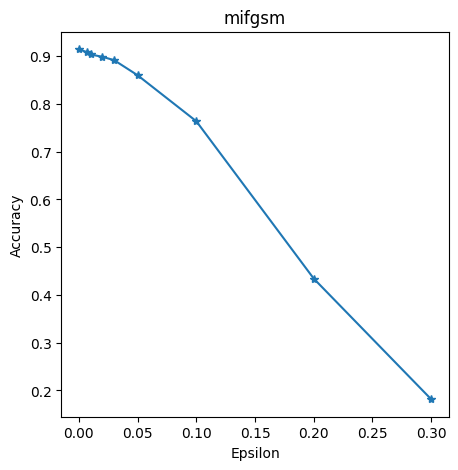

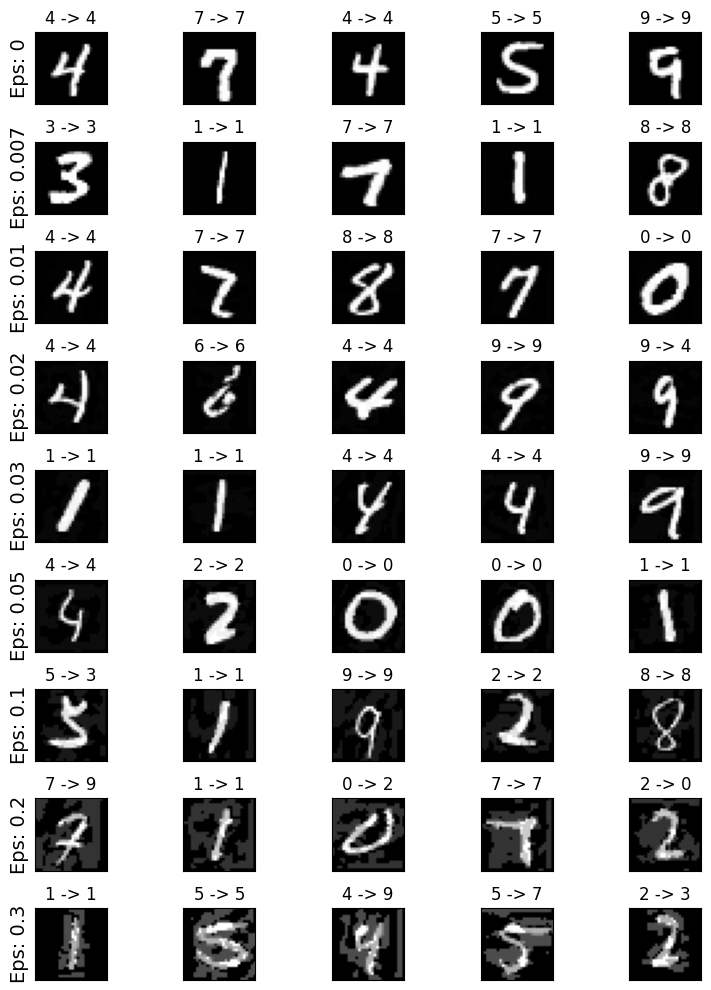

In [16]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)
